**Heat Transfer Analysis of Electronic
Devices using Neural Networks**

**Team 17**

**Team Members: Nitya Tiwari (22b2155) , Pranab Baro (22b2224) ,
Rochan Prasad (22b2248)**

In [ ]:
#Importing necessary libraries
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from scipy.stats import pearsonr
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import Parameter as TorchParam
from torch import Tensor
from typing import List, Tuple

In [ ]:
#data analysis
path_to_csv = '/content/measures_v2.csv'
data = pd.read_csv(path_to_csv)
print("First few rows of the DataFrame:")
print(data.head())
print("\n Summary statistics of numerical columns:")
print(data.describe())
print("\n Data types and missing values:")
print(data.info())

First few rows of the DataFrame:
        u_q    coolant  stator_winding       u_d  stator_tooth  motor_speed  \
0 -0.450682  18.805172       19.086670 -0.350055     18.293219     0.002866   
1 -0.325737  18.818571       19.092390 -0.305803     18.294807     0.000257   
2 -0.440864  18.828770       19.089380 -0.372503     18.294094     0.002355   
3 -0.327026  18.835567       19.083031 -0.316199     18.292542     0.006105   
4 -0.471150  18.857033       19.082525 -0.332272     18.291428     0.003133   

        i_d       i_q         pm  stator_yoke    ambient    torque  profile_id  
0  0.004419  0.000328  24.554214    18.316547  19.850691  0.187101        17.0  
1  0.000606 -0.000785  24.538078    18.314955  19.850672  0.245417        17.0  
2  0.001290  0.000386  24.544693    18.326307  19.850657  0.176615        17.0  
3  0.000026  0.002046  24.554018    18.330833  19.850647  0.238303        17.0  
4 -0.064317  0.037184  24.565397    18.326662  19.850639  0.208197        17.0  

 Summ

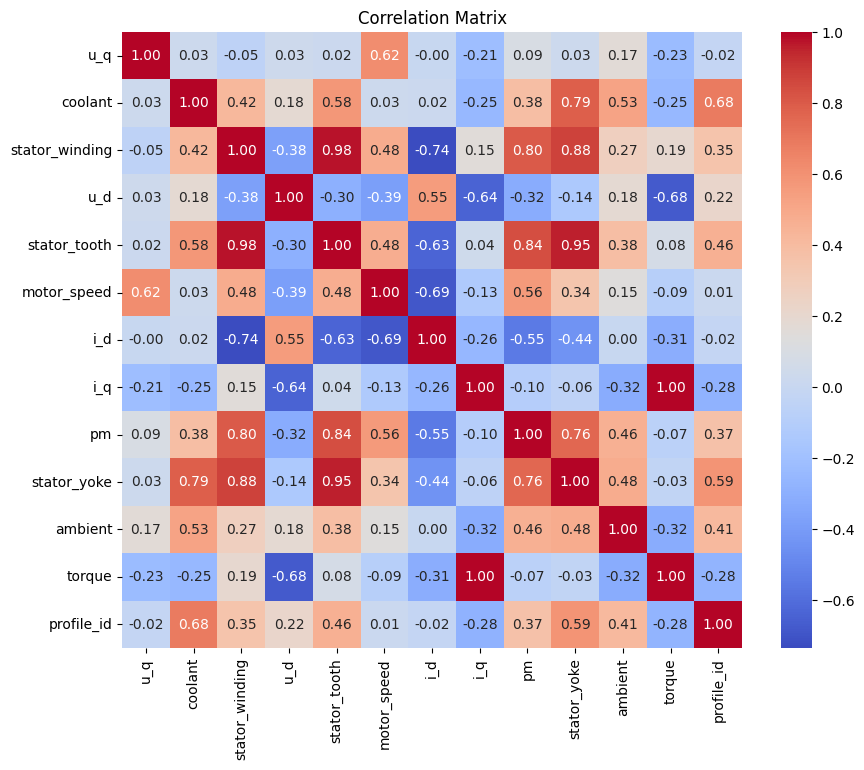

In [ ]:
# Correlation matrix
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


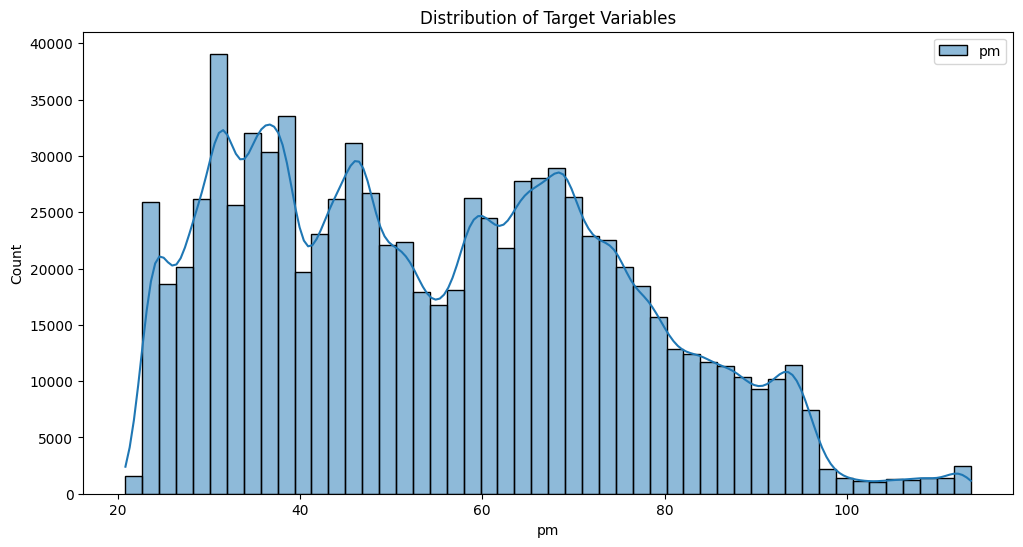

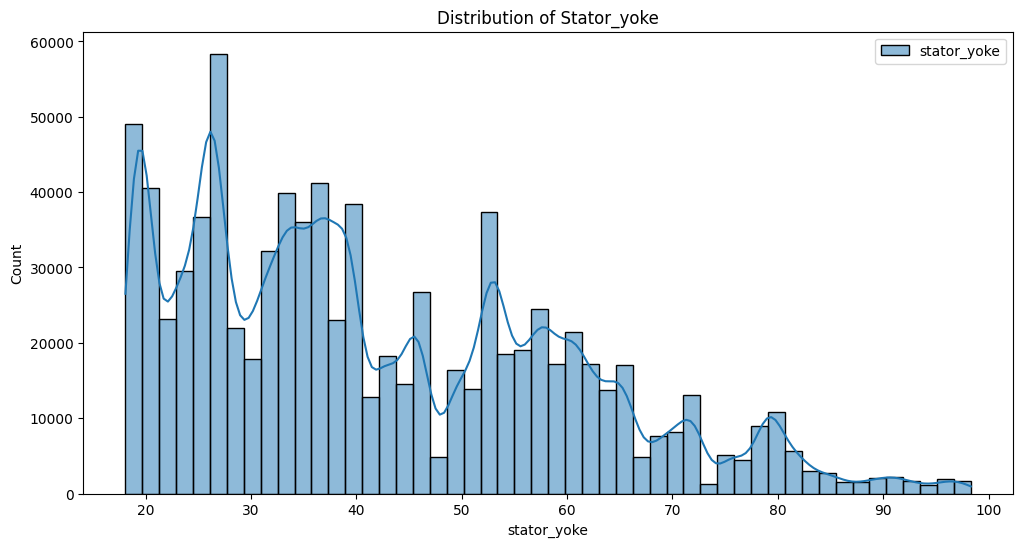

In [ ]:
# Distribution of target variables
plt.figure(figsize=(12, 6))
for col in ['pm']:
    sns.histplot(data[col], kde=True, bins=50, alpha=0.5, label=col)
plt.title('Distribution of Target Variables')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
for col in ['stator_yoke']:
    sns.histplot(data[col], kde=True, bins=50, alpha=0.5, label=col)
plt.title('Distribution of Stator_yoke')
plt.legend()
plt.show()

In [ ]:
# Boxplot of target variables by profile_id
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='stator_winding', y='pm')
plt.title('Boxplot of pm by profile_id')
plt.show()

input_cols = ['u_q', 'coolant', 'stator_winding', 'u_d', 'stator_tooth', 'motor_speed',
              'i_d', 'i_q', 'pm', 'stator_yoke', 'ambient', 'torque', 'profile_id']

         PC1       PC2
0 -63.480989  3.515550
1 -63.483620  3.532471
2 -63.479253  3.526106
3 -63.478828  3.515260
4 -63.476462  3.504387


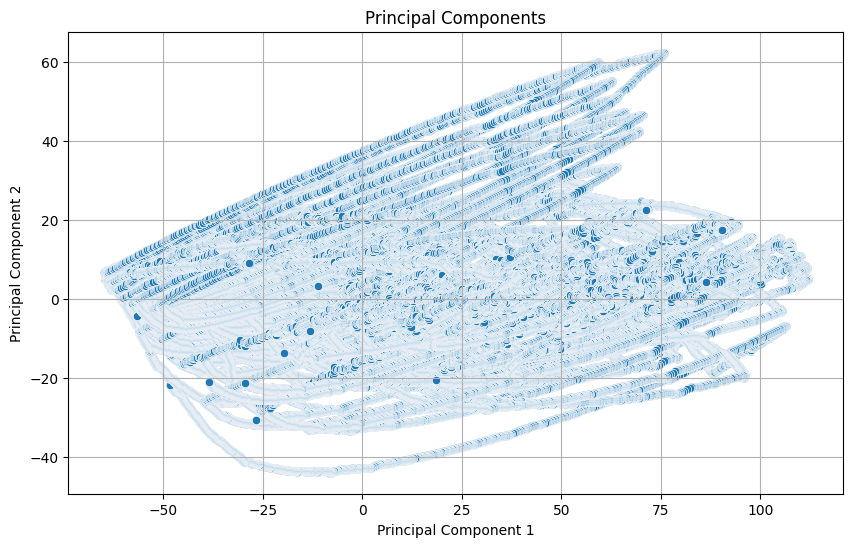

In [ ]:
# Impute missing values
imputer = SimpleImputer(strategy='mean')
input_cols = ['stator_winding', 'stator_tooth', 'pm', 'stator_yoke']
data_imputed = imputer.fit_transform(data[input_cols])

# Perform PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_imputed)


# Create a DataFrame from the transformed data
pca_df = pd.DataFrame(data=data_pca, columns=['PC1', 'PC2'])
print(pca_df.head())

# Plot the principal components
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df)
plt.title('Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()



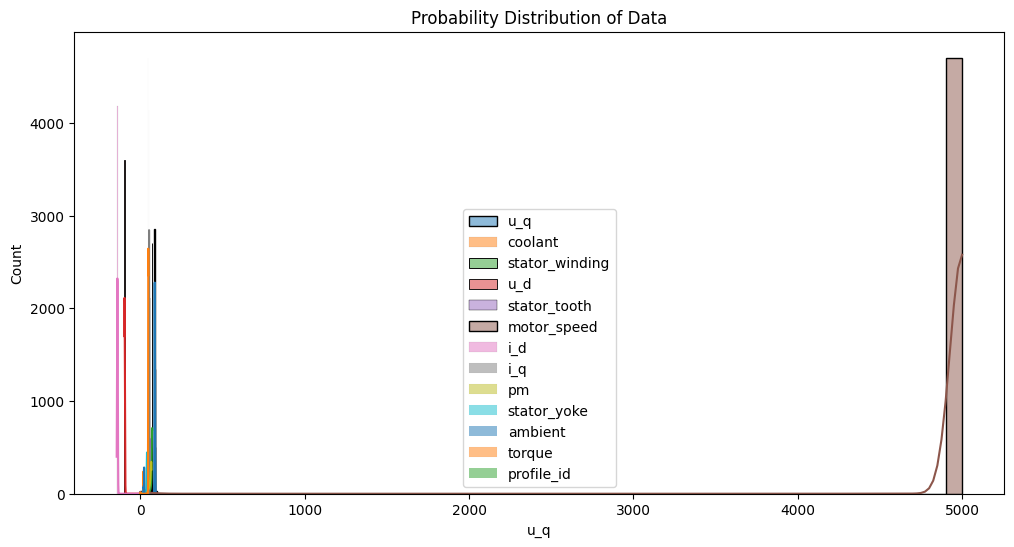

In [ ]:
# Plot probability distribution of data
plt.figure(figsize=(12, 6))
for col in data.columns:
    sns.histplot(data[col], kde=True, bins=50, alpha=0.5, label=col)
plt.title('Probability Distribution of Data')
plt.legend()
plt.show()

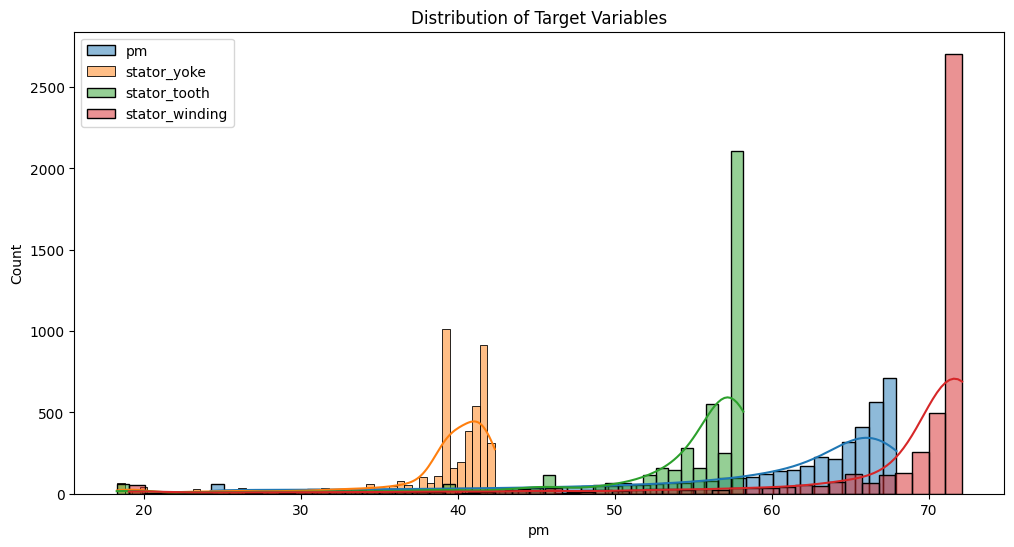

In [ ]:
plt.figure(figsize=(12, 6))

# Plot histogram for 'pm'
sns.histplot(data['pm'], kde=True, bins=50, alpha=0.5, label='pm')
# Plot histogram for 'stator_yoke'
sns.histplot(data['stator_yoke'], kde=True, bins=50, alpha=0.5, label='stator_yoke')
# Plot histogram for 'stator_tooth'
sns.histplot(data['stator_tooth'], kde=True, bins=50, alpha=0.5, label='stator_tooth')
# Plot histogram for 'stator_winding'
sns.histplot(data['stator_winding'], kde=True, bins=50, alpha=0.5, label='stator_winding')

plt.title('Distribution of Target Variables')
plt.legend()
plt.show()


In [ ]:
#Setting up data
target_cols = ["pm", "stator_yoke", "stator_tooth", "stator_winding"]

temperature_cols = target_cols + ["ambient", "coolant"]
test_profiles = [30, 31, 32]
train_profiles = [p for p in data.profile_id.unique() if p not in test_profiles]
profile_sizes = data.groupby("profile_id").agg("size")

# normalize
non_temperature_cols = [c for c in data if c not in temperature_cols + ["profile_id"]]
data.loc[:, temperature_cols] /= 200  # deg C
data.loc[:, non_temperature_cols] /= data.loc[:, non_temperature_cols].abs().max(axis=0)

# extra feats (FE)
if {"i_d", "i_q", "u_d", "u_q"}.issubset(set(data.columns.tolist())):
    extra_feats = {
        "i_s": lambda x: np.sqrt((x["i_d"] ** 2 + x["i_q"] ** 2)),
        "u_s": lambda x: np.sqrt((x["u_d"] ** 2 + x["u_q"] ** 2)),
    }
data = data.assign(**extra_feats)
input_cols = [c for c in data.columns if c not in target_cols]
device = torch.device("cpu")
print(test_profiles)

[30, 31, 32]


In [ ]:
#inspecting error
profile_sizes.dropna
train_profiles = [x for x in train_profiles if x in profile_sizes.index]
test_profiles = [x for x in test_profiles if x in profile_sizes.index]
train_profiles = [x for x in train_profiles if pd.notna(x)]
#test_profiles = [x for x in test_profiles if pd.notna(x)]
print(profile_sizes)
print(train_profiles)
print(test_profiles)

profile_id
2.0     19357
3.0     19248
4.0     33424
5.0     14788
6.0     40388
7.0     14651
8.0     18757
9.0     20336
10.0    15256
11.0     7887
12.0    21942
13.0    35906
14.0    18598
15.0    18124
16.0    20645
17.0    15964
18.0    37732
19.0    10410
20.0    43971
21.0    17321
23.0    11856
24.0    15015
26.0    16666
27.0    35361
29.0    21358
30.0    23863
31.0    15587
32.0    20960
36.0    19893
dtype: int64
[17.0, 5.0, 12.0, 21.0, 2.0, 4.0, 7.0, 19.0, 3.0, 9.0, 23.0, 27.0, 26.0, 11.0, 6.0, 10.0, 13.0, 18.0, 29.0, 8.0, 24.0, 20.0, 15.0, 14.0, 16.0, 36.0]
[30, 31, 32]


In [ ]:
profile_sizes.index

Float64Index([ 2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0, 10.0, 11.0, 12.0,
              13.0, 14.0, 15.0, 17.0, 18.0, 19.0, 20.0, 21.0, 23.0, 24.0, 26.0,
              27.0, 29.0, 30.0, 31.0, 32.0],
             dtype='float64', name='profile_id')

In [ ]:
# Rearrange features
input_cols = [c for c in data.columns if c not in target_cols + ["profile_id"]]
data = data.loc[:, input_cols + ["profile_id"] + target_cols]

def generate_tensor(profiles_list):
    """Returns profiles of the data set in a coherent 3D tensor with
    time-major shape (T, B, F) where
    T : Maximum profile length
    B : Batch size = Amount of profiles
    F : Amount of input features.

    Also returns a likewise-shaped sample_weights tensor, which zeros out post-padded zeros for use
    in the cost function (i.e., it acts as masking tensor)"""
    max_profile_length = profile_sizes[profiles_list].max()
    if pd.isna(max_profile_length):
      max_profile_length = 0  # If max_profile_length is NaN, set it to 0
    else:
      max_profile_length = int(max_profile_length)  # Otherwise, cast it to an integer

    tensor = np.full((max_profile_length, len(profiles_list), data.shape[1] - 1), np.nan,)


    for i, (pid, df) in enumerate(
        data.loc[data.profile_id.isin(profiles_list), :].groupby("profile_id")
    ):
        assert pid in profiles_list, f"PID is not in {profiles_list}!"
        tensor[: len(df), i, :] = df.drop(columns="profile_id").to_numpy()
    sample_weights = 1 - np.isnan(tensor[:, :, 0])
    tensor = np.nan_to_num(tensor).astype(np.float32)
    tensor = torch.from_numpy(tensor).to(device)
    sample_weights = torch.from_numpy(sample_weights).to(device)
    return tensor, sample_weights

train_tensor, train_sample_weights = generate_tensor(train_profiles)
test_tensor, test_sample_weights = generate_tensor(test_profiles)

In [ ]:
#wtf is the error
print(profile_sizes[train_profiles].max())
print(len(train_profiles))
print(data.shape[1] - 1)

43971
26
14


In [ ]:
#generated tensor wtff
print(f"test_tensor shape: {test_tensor.shape}")
print(f"train_tensor shape: {train_tensor.shape}")

test_tensor shape: torch.Size([23863, 3, 14])
train_tensor shape: torch.Size([43971, 26, 14])


In [ ]:
#Model
class DiffEqLayer(nn.Module):
    """This class is a container for the computation logic in each step.
    This layer could be used for any 'cell', also RNNs, LSTMs or GRUs."""

    def __init__(self, cell, *cell_args):
        super().__init__()
        self.cell = cell(*cell_args)

    def forward(self, input: Tensor, state: Tensor) -> Tuple[Tensor, Tensor]:
        inputs = input.unbind(0)
        outputs = torch.jit.annotate(List[Tensor], [])
        for i in range(len(inputs)):
            out, state = self.cell(inputs[i], state)
            outputs += [out]
        return torch.stack(outputs), state


class TNNCell(nn.Module):
    """The main TNN logic. Here, the sub-NNs are initialized as well as the constant learnable
    thermal capacitances. The forward function houses the LPTN ODE discretized with the explicit Euler method
    """

    def __init__(self):
        super().__init__()
        self.sample_time = 0.5  # in s
        self.output_size = len(target_cols)
        self.caps = TorchParam(torch.Tensor(self.output_size).to(device))
        nn.init.normal_(
            self.caps, mean=-9.2, std=0.5
        )  # hand-picked init mean, might be application-dependent
        n_temps = len(temperature_cols)  # number of temperatures (targets and input)
        n_conds = int(0.5 * n_temps * (n_temps - 1))  # number of thermal conductances
        # conductance net sub-NN
        self.conductance_net = nn.Sequential(
            nn.Linear(len(input_cols) + self.output_size, n_conds), nn.Sigmoid()
        )
        # populate adjacency matrix. It is used for indexing the conductance sub-NN output
        self.adj_mat = np.zeros((n_temps, n_temps), dtype=int)
        adj_idx_arr = np.ones_like(self.adj_mat)
        triu_idx = np.triu_indices(n_temps, 1)
        adj_idx_arr = adj_idx_arr[triu_idx].ravel()
        self.adj_mat[triu_idx] = np.cumsum(adj_idx_arr) - 1
        self.adj_mat += self.adj_mat.T
        self.adj_mat = torch.from_numpy(self.adj_mat[: self.output_size, :]).type(
            torch.int64
        )  # crop
        self.n_temps = n_temps

        # power loss sub-NN
        self.ploss = nn.Sequential(
            nn.Linear(len(input_cols) + self.output_size, 16),
            nn.Tanh(),
            nn.Linear(16, self.output_size),
        )

        self.temp_idcs = [i for i, x in enumerate(input_cols) if x in temperature_cols]
        self.nontemp_idcs = [
            i
            for i, x in enumerate(input_cols)
            if x not in temperature_cols + ["profile_id"]
        ]

    def forward(self, inp: Tensor, hidden: Tensor) -> Tuple[Tensor, Tensor]:
        prev_out = hidden
        temps = torch.cat([prev_out, inp[:, self.temp_idcs]], dim=1)
        sub_nn_inp = torch.cat([inp, prev_out], dim=1)
        conducts = torch.abs(self.conductance_net(sub_nn_inp))
        power_loss = torch.abs(self.ploss(sub_nn_inp))
        temp_diffs = torch.sum(
            (temps.unsqueeze(1) - prev_out.unsqueeze(-1)) * conducts[:, self.adj_mat],
            dim=-1,
        )
        out = prev_out + self.sample_time * torch.exp(self.caps) * (
            temp_diffs + power_loss
        )
        return prev_out, torch.clip(out, -1, 5)

In [ ]:
#Training
model = torch.jit.script(DiffEqLayer(TNNCell).to(device))
loss_func = nn.MSELoss(reduction="none")
opt = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 6
tbptt_size = 512

n_batches = np.ceil(train_tensor.shape[0] / tbptt_size).astype(int)
with tqdm(desc="Training", total=n_epochs) as pbar:
    for epoch in range(n_epochs):
        # first state is ground truth temperature data
        hidden = train_tensor[0, :, -len(target_cols) :]

        # propagate batch-wise through data set
        for i in range(n_batches):
            model.zero_grad()
            output, hidden = model(
                train_tensor[
                    i * tbptt_size : (i + 1) * tbptt_size, :, : len(input_cols)
                ],
                hidden.detach(),
            )
            loss = loss_func(
                output,
                train_tensor[
                    i * tbptt_size : (i + 1) * tbptt_size, :, -len(target_cols) :
                ],
            )
            # sample_weighting
            loss = (
                (
                    loss
                    * train_sample_weights[
                        i * tbptt_size : (i + 1) * tbptt_size, :, None
                    ]
                    / train_sample_weights[
                        i * tbptt_size : (i + 1) * tbptt_size, :
                    ].sum()
                )
                .sum()
                .mean()
            )
            loss.backward()
            opt.step()

        # reduce learning rate
        if epoch == 75:
            for group in opt.param_groups:
                group["lr"] *= 0.5
        pbar.update()
        pbar.set_postfix_str(f"loss: {loss.item():.2e}")

Training: 100%|██████████| 6/6 [03:23<00:00, 33.97s/it, loss: 1.94e-02]


In [ ]:
#Testing
with torch.no_grad():
    pred, hidden = model(
        test_tensor[:, :, : len(input_cols)], test_tensor[0, :, -len(target_cols) :]
    )
    pred = pred.cpu().numpy() * 200  # denormalize

In [ ]:
#more error :(
print(f"test_tensor shape: {test_tensor.shape}")
print(f"input_cols: {input_cols}")
print(f"target_cols: {target_cols}")
print(f"len(input_cols): {len(input_cols)}")
print(f"len(target_cols): {len(target_cols)}")

test_tensor shape: torch.Size([0, 0, 14])
input_cols: ['u_q', 'coolant', 'u_d', 'motor_speed', 'i_d', 'i_q', 'ambient', 'torque', 'i_s', 'u_s']
target_cols: ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']
len(input_cols): 10
len(target_cols): 4


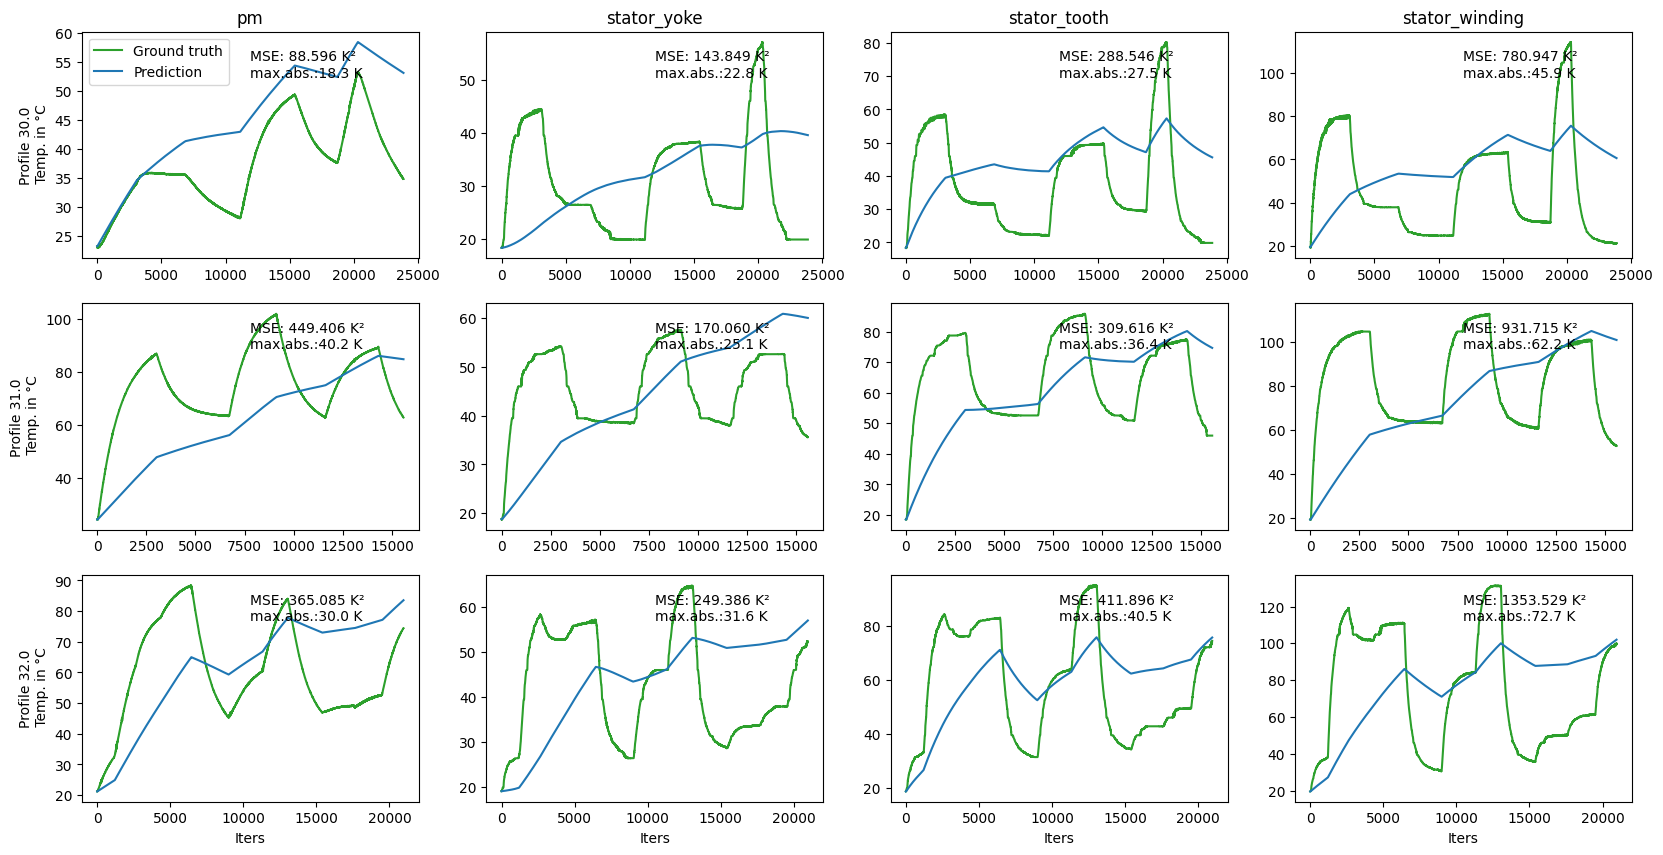

In [ ]:
#Visualizing stuff
fig, axes = plt.subplots(len(test_profiles), len(target_cols), figsize=(20, 10))
for i, (pid, y_test) in enumerate(
    data.loc[data.profile_id.isin(test_profiles), target_cols + ["profile_id"]].groupby(
        "profile_id"
    )
):
    y_test *= 200
    profile_pred = pred[: len(y_test), i, :]
    for j, col in enumerate(target_cols):
        ax = axes[i, j]
        ax.plot(
            y_test.loc[:, col].reset_index(drop=True),
            color="tab:green",
            label="Ground truth",
        )
        ax.plot(profile_pred[:, j], color="tab:blue", label="Prediction")
        ax.text(
            x=0.5,
            y=0.8,
            s=f"MSE: {((profile_pred[:, j] - y_test.loc[:, col])**2).sum() / len(profile_pred):.3f} K²\nmax.abs.:{(profile_pred[:, j]-y_test.loc[:, col]).abs().max():.1f} K",
            transform=ax.transAxes,
        )
        if j == 0:
            ax.set_ylabel(f"Profile {pid}\n Temp. in °C")
            if i == 0:
                ax.legend()
        if i == len(test_profiles) - 1:
            ax.set_xlabel(f"Iters")
        elif i == 0:
            ax.set_title(col)

# its ok its just 6 epochs :')